# Analyse des commentaires
Dans ce notebook, nous allons regarder en détail les commentaires laissés par les utilisateurs.
Le travail sera divisé en deux parties : Construction du corpus et Début ? d'analyse des fréquences

In [2]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import NMF, Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from itertools import product
from scipy import sparse

from reco_systems.filter import filter_df
import reco_systems.bigram_evaluation as bev
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Functions

In [3]:
def words_freq(data, corpus) -> pd.DataFrame:
    """
    Construction d'un dataframe avec la fréquence des mots dans un corpus
    """

    lem, occurences = np.unique(data['Lemma'], return_counts=True)

    df = pd.DataFrame({'Lemma': lem, 'Freq': occurences})
    nb_comments = data["Comment line"].nunique()
    df['Freq'] = df['Freq'].apply(lambda val: val/nb_comments)

    # Garder uniquement les lemmas qui appraissent dans le corpus
    #return df[df['Lemma'].isin(corpus)]
    return df

def construction_corpus(lemmas:pd.DataFrame, taille: int) -> dict:
    """ 
    Construction d'un corpus à partir d'une BDD de commentaires
    avis.colums = 'Comment title', 'Comment body'

    Retourne df avec mots du corpus et leurs fréquences, les 'taille' plus fréquentes
    """

    # Corpus creation from lemmatized dataframe
    lemmas = lemmas[~lemmas["Lemma"].isna()]
    lemmas = lemmas[lemmas['Part of speech'].isin(['ADJ', 'NOM', "VER", "NEG"])]
    lemmas = lemmas[~lemmas["Lemma"].isin(["bref", "bof", "excelent", "bon", "autre", "seul", "tendre", "fin"
                                           "super", "superbe", "juste", "jouable", "ca", "faire", "pouvoir", "ausi"])]
    lemmas = lemmas['Lemma'].to_numpy()

    # Occurencies calculation for each lemma
    lem, occ = np.unique(lemmas, return_counts=True)
    freq_lem = pd.DataFrame({'lemma': lem, 'freq': occ})

    freq_lem = freq_lem.sort_values(by=['freq'], ascending=False)
    return freq_lem.head(taille)['lemma'].to_numpy()

#### Data

In [4]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=np.arange(0, rev_filter.shape[0]))
rev_filter_center, _= center_score(rev_filter)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


### Corpus 5000 mots

In [5]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
corpus = construction_corpus(lemmas, 5000) 
lemmas = lemmas[lemmas["Lemma"].isin(corpus)] # only words in corpus

# Joined lemmas
comments = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})

### NMF 20 latent factors

In [6]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]

### 30 KMeans games clusters 

In [7]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id" : np.sort(games_ids), "Cluster" : kmeans.labels_})

In [8]:
# Séparation de la bdd 
positifs = rev_filter_center[rev_filter_center['Rating'] >= 0]
negatifs = rev_filter_center[rev_filter_center['Rating'] < 0]

print("Nombre d'avis negatif", len(negatifs)/len(rev_filter_center))
print("Nombre d'avis positif", len(positifs)/len(rev_filter_center))

Nombre d'avis negatif 0.43073353153843763
Nombre d'avis positif 0.5692664684615624


In [9]:
lemmas_pos = positifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_neg = negatifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_pos = lemmas_pos.drop(["index"], axis=1)
lemmas_neg = lemmas_neg.drop(["index"], axis=1)

lemmas_all = rev_filter[["User id", "Game id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_all = lemmas_all.drop(["index"], axis=1)

In [10]:
comments_neg = lemmas_neg.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_neg = comments_neg.assign(pos_neg = "negative")

comments_pos = lemmas_pos.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_pos = comments_pos.assign(pos_neg = "positive")

comments_all = pd.concat([comments_neg, comments_pos])
comments_all_count = comments_all[["Game id", "pos_neg", "User id"]].groupby(["Game id", "pos_neg"]).count().rename(columns={"User id":"count"}).reset_index()

In [11]:
rev_neg_count = comments_neg["Game id"].value_counts().reset_index()
rev_pos_count = comments_pos["Game id"].value_counts().reset_index()

# Filter games so that each game has at least 10 pos and 10 neg reviews
games_preserved = rev_neg_count[rev_neg_count["Game id"].isin(rev_pos_count.loc[rev_pos_count["count"] >= 10, "Game id"])
                                & rev_neg_count["Game id"].isin(rev_neg_count.loc[rev_neg_count["count"] >= 10, "Game id"])]["Game id"].values
                                
mask = np.isin(np.sort(games_ids), games_preserved)

# Games clusters contains only games that were filtered
games_clusters = pd.DataFrame(data={"Game id":np.sort(games_ids)[mask], "Cluster":kmeans.labels_[mask]})

In [12]:
# Barplot the distribution of pos/neg comments
def plot_pos_neg_games(selected_games, comments_all_count, title, all=False):
    sns.set_theme(rc={"figure.figsize":(15, 6)})
    filtered = comments_all_count[comments_all_count["Game id"].isin(selected_games["Game id"])]
    if not all:
        filtered = filtered.head(50)
    ax = sns.barplot(data=filtered, x="Game id", y="count", hue="pos_neg", errorbar=None)
    ax.set_title(title)
    if all:
        ax.set(xticklabels=[])

def create_df(ngram_finder, ngram_stat):
        bigram_freq = ngram_finder.score_ngrams(ngram_stat)

        bigrams_df = pd.DataFrame(data=[list(info) for info in bigram_freq])
        bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
        bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})
        return bigrams_df

def get_Ngrams(game, ngram_finder, ngram_stat):
    comments_pos = lemmas_pos[lemmas_pos["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    comments_neg = lemmas_neg[lemmas_neg["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    
    #if comments_pos.size > 0:
    bigram_finder_pos = ngram_finder.from_documents(comments_pos)
    freq_pos = create_df(bigram_finder_pos, ngram_stat)
    #if comments_neg.size > 0:
    bigram_finder_neg = ngram_finder.from_documents(comments_neg)
    freq_neg = create_df(bigram_finder_neg, ngram_stat)
    
    diff_freq = ft.diff_freq(freq_pos, freq_neg)

    return freq_pos, freq_neg, diff_freq

def plot_games_Ngrams_freq_diff(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows - 1, 2), range(ncols)))):
        mean = games_means[games_means["Game id"] == game]["Rating"].item()

        _, _, diff_check_games = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=diff_check_games.head(20), y="Lemma", x="Freq differency", ax=axes[i, j])
        sns.barplot(data=diff_check_games.tail(20), y="Lemma", x="Freq differency", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head freq_diff {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} tail freq_diff {mean:.2f}")

    plt.tight_layout()

def plot_games_Ngrams_all(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows, 2), range(ncols)))):
        
        mean = games_means[games_means["Game id"] == game]["Rating"].item()
        pos, neg, _ = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=pos.head(20), y="Lemma", x="Freq", ax=axes[i, j])
        sns.barplot(data=neg.head(20), y="Lemma", x="Freq", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head pos {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} head neg {mean:.2f}")

    plt.tight_layout()

### Bigrams

### User recommendation KNN

In [13]:
# Init
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
top_users = rev_filter[["User id", "Rating"]].groupby("User id").count().reset_index().sort_values(by="Rating", ascending=False)["User id"].values

games_to_consider = games_clusters["Game id"].values

users_mean = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()

---

### Using tf idf to filter bigrams

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# lemmatized comments
all_doc = comments_all['Lemma']
vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=5, max_df=0.8) # bigrams
vectors = vectorizer.fit_transform(all_doc)

In [15]:
bigrams_ens = vectorizer.get_feature_names_out()

In [16]:
comments_all = comments_all.drop(columns=['Comment line']).reset_index()
comments_all = comments_all.drop(columns=['index']).reset_index()

In [17]:
# plotting for the threshold
tfidf_value = vectors.data

In [18]:
bins = np.arange(0, 1.01, 0.01)
counts, bin_edges = np.histogram(tfidf_value, bins=bins)
counts, bin_edges

(array([     0,    173,   3216,  11651,  25298,  43392,  64701,  86765,
        105300, 120016, 131414, 135826, 136599, 131718, 124875, 118437,
        107089,  96420,  85933,  77356,  66888,  58366,  51159,  44247,
         37981,  32523,  27776,  23970,  20044,  16994,  14561,  12392,
         10639,   9127,   7857,   6806,   5829,   4887,   4258,   3587,
          3167,   2684,   2242,   2061,   1721,   1524,   1344,   1146,
          1041,    887,    763,    637,    559,    492,    415,    356,
           331,    283,    268,    238,    190,    183,    168,    125,
           106,    106,     95,     74,     86,     74,     93,     75,
            55,     48,     50,     35,     27,     31,     23,     24,
            20,      9,     12,     14,      8,      9,     11,      6,
             7,      6,      5,      1,      1,      3,      2,      2,
             0,      1,      0,    112]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 

In [19]:
df_plot = pd.DataFrame({
    'Interval': bin_edges[:-1],
    'Count': counts
})
df_plot

,Interval,Count
0,0.00,0
1,0.01,173
2,0.02,3216
3,0.03,11651
4,0.04,25298
...,...,...
95,0.95,2
96,0.96,0
97,0.97,1
98,0.98,0


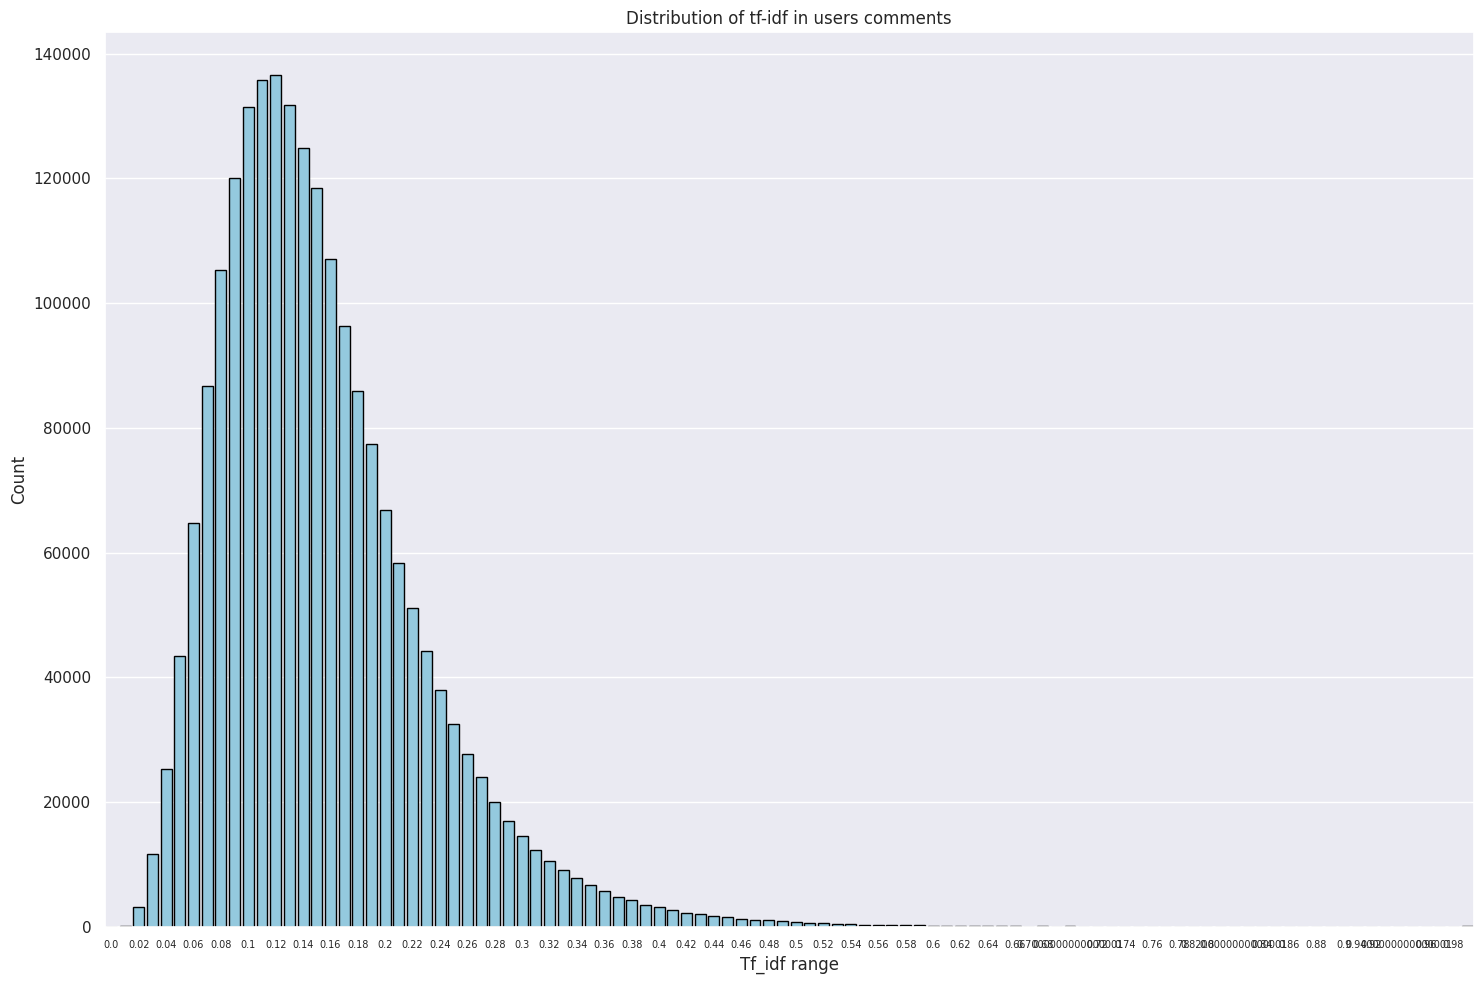

In [22]:
plt.figure(figsize=(15,10))
ax = sns.barplot(data=df_plot, x='Interval', y='Count', color='skyblue', edgecolor='black')

plt.xlabel('Tf_idf range', )
plt.ylabel('Count')
plt.title('Distribution of tf-idf in users comments')
plt.xticks(fontsize=7)        

xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()

# Turn off all labels first
for label in xticklabels:
    label.set_visible(False)

# Turn on every 5th label
for i in range(0, len(xticklabels), 2):
    xticklabels[i].set_visible(True)

plt.tight_layout()
plt.show()

In [23]:
density = [sum(counts[i:]) for i in range(len(counts))]

In [24]:
density_df = pd.DataFrame({"Count" : density, "Interv": bin_edges[:-1]})
density_df[density_df['Interv'] == 0.13]

,Count,Interv
13,1225775,0.13


<Axes: xlabel='Interv', ylabel='Count'>

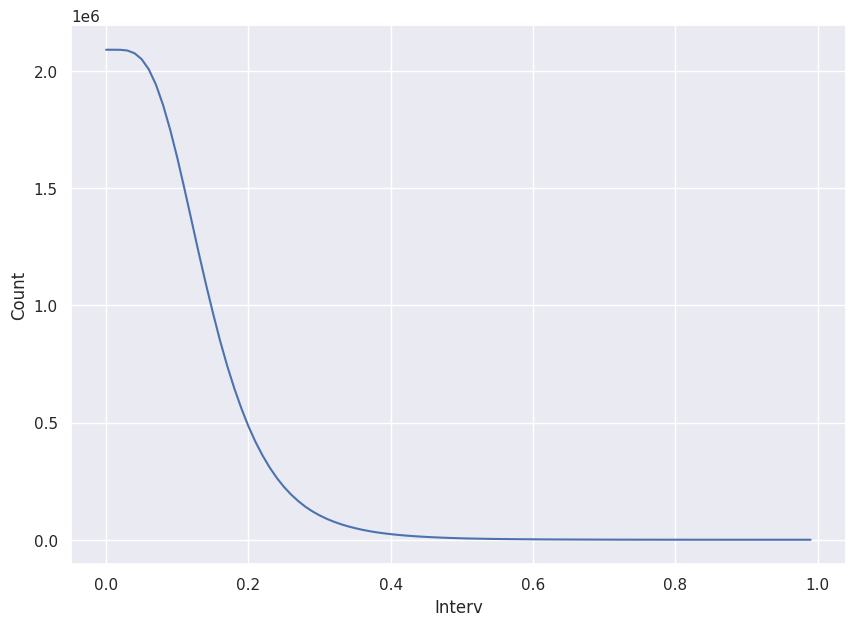

In [25]:
plt.figure(figsize=(10,7))
sns.lineplot(density_df, x='Interv', y='Count')

In [26]:
# # using tf idf filtering, count number of intersection in neg and pos
# def count_intersect(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id, threshold): # user id 

#         # _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

#         def f_all_comment(comment_grp): # filters the bigrams of comment using tf idf
#             document = np.array([])

#             for index, lem in zip(comment_grp['index'], comment_grp['Lemma']): 
#                 g = BigramCollocationFinder.from_words(lem.split()).score_ngrams(BigramAssocMeasures.raw_freq)
#                 values = vectors[index].data  # Non-zero values in the sparse matrix
#                 mask = values >= threshold
#                 values = values[mask]
#                 indices = vectors[index].indices[mask]
#                 keep_bigrams = bigrams_ens[indices[np.argsort(values)[::-1]]]
#                 kept = np.array([" ".join(bigram) for bigram, _ in g if " ".join(bigram) in keep_bigrams])
#                 if kept.size != 0:
#                     document = np.concatenate((document,kept), axis = 0)
#             return document        
        
#         def filtered_big_df(df): # construct frequency lemma df
#             bigrams_comments = df.groupby('User id').apply(f_all_comment,include_groups=False).reset_index(drop=True).values
#             if bigrams_comments.size != 0:
#                 bigrams_comments = np.hstack(bigrams_comments)
#             val, count = np.unique(bigrams_comments, return_counts=True)
#             count = count/len(bigrams_comments)
#             return pd.DataFrame({"Lemma": val, 'Freq': count})

#         # Negatives comments
#         bigrams_neg = filtered_big_df(sim_users_neg)        
#         bigrams_neg_user = filtered_big_df(user_neg)

#         # Find intersection
#         bigrams_neg = bigrams_neg[bigrams_neg["Lemma"].isin(bigrams_neg_user["Lemma"])]
#         bigrams_neg_user = bigrams_neg_user[bigrams_neg_user["Lemma"].isin(bigrams_neg["Lemma"])]

#         # # Positive comments
#         bigrams_pos = filtered_big_df(sim_users_pos)
#         bigrams_pos_user = filtered_big_df(user_pos)
        
#         # Find intersection
#         bigrams_pos = bigrams_pos[bigrams_pos["Lemma"].isin(bigrams_pos_user["Lemma"])]
#         bigrams_pos_user = bigrams_pos_user[bigrams_pos_user["Lemma"].isin(bigrams_pos["Lemma"])]

#         return  len(bigrams_pos), len(bigrams_neg)

# # type: random, simi, less_simi
# def knn_comments(user_id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type = 'simi', threshold = 0, k = 40):    
#     # rating matrix
#     user_ind = users_table[users_table == user_id].index[0]
#     games_to_hide = np.random.choice(games_to_consider, size=200, replace=False)
#     hidden_games = np.intersect1d(games_table[games_table.isin(games_to_hide)].index, mask_ratings[user_ind, :].nonzero()[0])
#     prev_ratings, prev_mask_ratings = matrix_ratings[user_ind, :], mask_ratings[user_ind, :], 
#     prev_sim = cos_sim_matrix[user_ind, :]

#     # hide games
#     matrix_ratings[user_ind, hidden_games] = 0
#     mask_ratings[user_ind, hidden_games] = 0

#     recalc_cos_similarity(user_ind, matrix_ratings, cos_sim_matrix)

#     # choice of neighbors
#     match type:
#         case 'simi':
#             sim_users = get_KNN(cos_sim_matrix, k, user_ind)
#         case 'less_simi':
#             sim_users = get_KNN(cos_sim_matrix, users_table.shape[0], user_ind)[-k:] # furthest
#         case 'random':
#             sim_users = get_KNN(cos_sim_matrix, users_table.shape[0], user_ind) # random
#             sim_users = np.random.choice(sim_users, size=k, replace=False)
            
#     pred_ratings, mask_pred_ratings = predict_ratings_baseline(matrix_ratings, mask_ratings,
#                                                                 sim_users, cos_sim_matrix, user_ind)
    
#     # restore
#     matrix_ratings[user_ind, :], mask_ratings[user_ind, :] = prev_ratings, prev_mask_ratings
#     cos_sim_matrix[user_ind, :], cos_sim_matrix[:, user_ind] = prev_sim, prev_sim

#     diff = np.abs(matrix_ratings[user_ind, hidden_games] - pred_ratings[hidden_games])

#     ALLOW_ERR = 2
#     user_mean = users_mean.loc[users_mean["User id"] == user_id, "Rating"].item()
#     pos, neg = pred_ratings[hidden_games] < user_mean, pred_ratings[hidden_games] > user_mean

#     neg_pred_games = hidden_games[np.argwhere(neg & (diff < ALLOW_ERR)).flatten()]
#     pos_pred_games = hidden_games[np.argwhere(pos & (diff < ALLOW_ERR)).flatten()]

#     # Find games ids
#     neg_pred_games = games_table[games_table.index.isin(neg_pred_games)].values
#     pos_pred_games =  games_table[games_table.index.isin(pos_pred_games)].values

#     # Find users ids
#     sim_users = users_table[users_table.index.isin(sim_users)].values
#     sim_users_neg = comments_all[comments_all["Game id"].isin(neg_pred_games) & comments_all["User id"].isin(sim_users)]
#     sim_users_pos = comments_all[comments_all["Game id"].isin(pos_pred_games) & comments_all["User id"].isin(sim_users)]
#     # print(pos_pred_games)
#     user_pos = comments_all[(comments_all["Game id"].isin(neg_pred_games)) & (comments_all["User id"] == user_id)]
#     user_neg = comments_all[(comments_all["Game id"].isin(pos_pred_games)) & (comments_all["User id"] == user_id)]

#     # print(sim_users_neg)
#     # print(f"User id : {user_id}, nb correct negative : {neg_pred_games.shape[0]}, nb correct positives : {pos_pred_games.shape[0]}")
#     # print(sim_users_neg.shape, sim_users_pos.shape, user_pos.shape, user_neg.shape)
    
#     pos_count, neg_count = count_intersect(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id, threshold)
#     return pos_count, neg_count

### 200 users no threshold, number of bigrams intersected

In [34]:
np.random.seed(90)
n_users = 200
users_ids_samp = comments_all.sample(n=n_users)['User id']

avg_pos_s_200 = []
avg_neg_s_200 = []
avg_pos_ls_200 = []
avg_neg_ls_200 = []
avg_pos_r_200 = []
avg_neg_r_200 = []

for id in users_ids_samp:
    # simi 
    pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'simi', threshold = -1, k = 40)
    avg_pos_s_200.append(pos)
    avg_neg_s_200.append(neg)

    # less_simi
    pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'less_simi', threshold = -1, k = 40)
    avg_pos_ls_200.append(pos)
    avg_neg_ls_200.append(neg)

    # random
    pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'random', threshold = -1, k = 40)
    avg_pos_r_200.append(pos)
    avg_neg_r_200.append(neg)

In [35]:
print(f"Average for 200 users no thresold, k=40\nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
      Less_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
      Random pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

Average for 200 users no thresold, k=40
Simi pos: 34.09, neg: 34.055      Less_simi pos: 0.415, neg: 0.38      Random pos: 6.23, neg: 5.88



#### Mean on 5 evaluations, 200 users

In [28]:
n_users = 200
for _ in range(5):
    users_ids_samp = comments_all.sample(n=n_users)['User id']

    avg_pos_s_200 = []
    avg_neg_s_200 = []
    avg_pos_ls_200 = []
    avg_neg_ls_200 = []
    avg_pos_r_200 = []
    avg_neg_r_200 = []

    for id in users_ids_samp:
        # simi
        pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type='simi', k=40, threshold=-1)
        avg_pos_s_200.append(pos)
        avg_neg_s_200.append(neg)

        # less_simi
        pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type='less_simi', k=40, threshold=-1)
        avg_pos_ls_200.append(pos)
        avg_neg_ls_200.append(neg)

        # random
        pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type='random', k=40, threshold=-1)
        avg_pos_r_200.append(pos)
        avg_neg_r_200.append(neg)

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [29]:
print(f"Average for 200 users no thresold, k=40\nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
      Less_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
      Random pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

Average for 200 users no thresold, k=40
Simi pos: 30.6, neg: 32.365      Less_simi pos: 0.305, neg: 0.42      Random pos: 6.09, neg: 6.15



In [30]:
def type_user_count_df(simi_pos, random_pos, less_simi_pos, simi_neg, random_neg, less_simi_neg):
    simi = pd.DataFrame({"count" : simi_pos, "User" : "Similar","Type" : "Positive Reviews"})
    random = pd.DataFrame({"count" : random_pos, "User" : "Random","Type" : "Positive Reviews"})
    less_simi = pd.DataFrame({"count" : less_simi_pos, "User" : "Less Similar","Type" : "Positive Reviews"})

    df_posneg = pd.concat([simi, less_simi, random])

    simi = pd.DataFrame({"count" : simi_neg, "User" : "Similar","Type" : "Negative Reviews"})
    random = pd.DataFrame({"count" : random_neg, "User" : "Random","Type" : "Negative Reviews"})
    less_simi = pd.DataFrame({"count" : less_simi_neg, "User" : "Less Similar","Type" : "Negative Reviews"})

    return pd.concat([df_posneg, simi, less_simi, random])

def df_user_type_mean(df_posneg):
    group_means = df_posneg.groupby(['User', 'Type'])['count'].mean().reset_index()
    group_means['Type'] = group_means['Type'].replace({'Negative Reviews': 'Mean Negative Reviews','Positive Reviews': 'Mean Positive Reviews'})
    user_order = ['Similar', 'Random', 'Less Similar'] 
    group_means['User'] = pd.Categorical(group_means['User'], categories=user_order, ordered=True)
    return group_means

def plot_posnegviolin(data, means, title, xlabel, ylabel, figname):
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, x="User", y="count", hue="Type",density_norm='width',order=["Similar", "Random", "Less Similar"], cut=0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    custom_palette = {
        'Mean Positive Reviews': '#4554ff', # nuance blue  
        'Mean Negative Reviews': '#ff6f00', # nuance orange
    }

    sns.stripplot(
        data=means,
        x='User',
        y='count',
        hue='Type',
        dodge=True,
        hue_order=['Mean Positive Reviews', 'Mean Negative Reviews'],       
        jitter=True,     
        marker='o', 
        palette=custom_palette,       
    )
    plt.savefig(f"../images/{figname}.png")


In [31]:
df_pos_neg_ntshold = type_user_count_df(avg_pos_s_200, avg_pos_r_200, avg_pos_ls_200, avg_neg_s_200, avg_neg_r_200, avg_neg_ls_200)
group_means_reset_not = df_user_type_mean(df_pos_neg_ntshold)

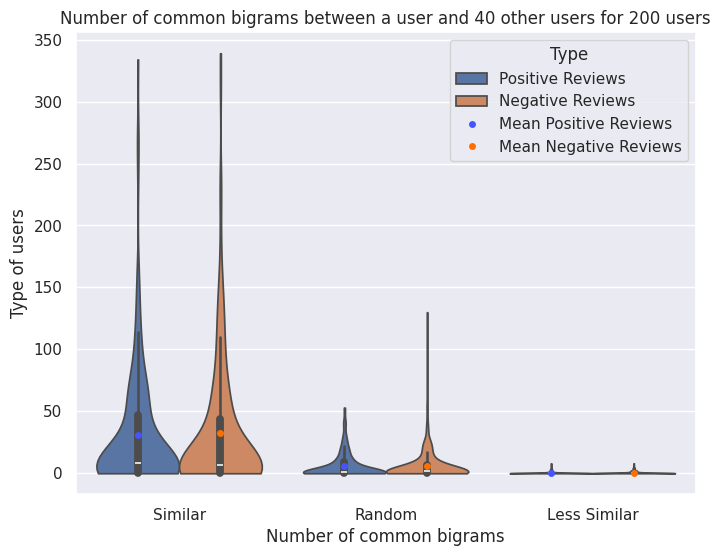

In [32]:
title = "Number of common bigrams between a user and 40 other users for 200 users"
xlab = "Number of common bigrams"
ylab = "Type of users"

plot_posnegviolin(df_pos_neg_ntshold, group_means_reset_not, title, xlab, ylab, "vplot_common_big_200_ntshold")

### With threshold = 0.13, number of bigrams intersected

In [33]:
threshold = 0.13
n_users = 200
for _ in range(5):
    users_ids_samp = comments_all.sample(n=n_users)['User id']

    avg_pos_s_200 = []
    avg_neg_s_200 = []
    avg_pos_ls_200 = []
    avg_neg_ls_200 = []
    avg_pos_r_200 = []
    avg_neg_r_200 = []

    for id in users_ids_samp:
        # simi
        pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'simi', threshold=threshold, k = 40)  
        avg_pos_s_200.append(pos)
        avg_neg_s_200.append(neg)

        # less_simi
        pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'less_simi', threshold=threshold, k = 40)
        avg_pos_ls_200.append(pos)
        avg_neg_ls_200.append(neg)

        # random
        pos, neg = bev.knn_comments_count(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'random', threshold=threshold, k = 40)
        avg_pos_r_200.append(pos)
        avg_neg_r_200.append(neg)
    

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/ana

In [34]:
print(f"Average for 200 users thresold = {threshold}, k=40\
    \nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
    \nLess_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
    \nRandom pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

Average for 200 users thresold = 0.13, k=40    
Simi pos: 7.845, neg: 9.25    
Less_simi pos: 0.015, neg: 0.02    
Random pos: 0.795, neg: 0.945



In [35]:
df_pos_neg = type_user_count_df(avg_pos_s_200, avg_pos_r_200, avg_pos_ls_200, avg_neg_s_200, avg_neg_r_200, avg_neg_ls_200)
group_means_reset = df_user_type_mean(df_pos_neg)

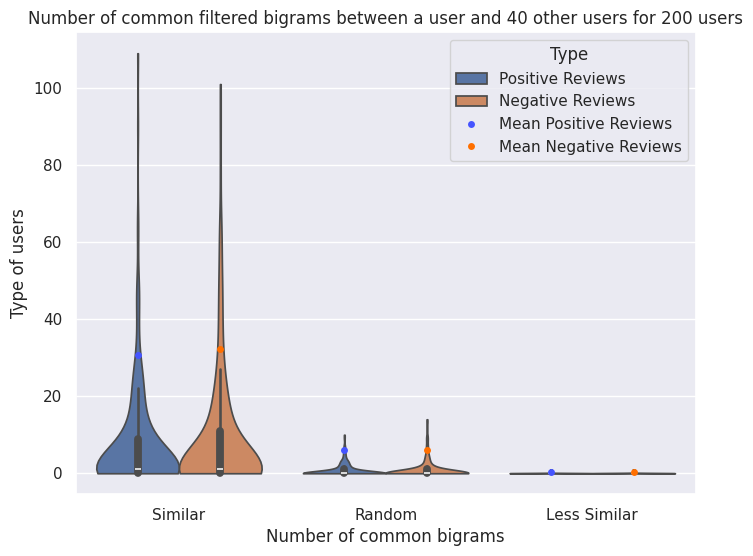

In [36]:
title = "Number of common filtered bigrams between a user and 40 other users for 200 users"
xlab = "Number of common bigrams"
ylab = "Type of users"

plot_posnegviolin(df_pos_neg,group_means_reset_not, title, xlab, ylab, "vplot_common_big_200")

### Gap between type of users, with and without threshold

In [37]:
def normal_df(data: pd.DataFrame) -> pd.DataFrame:
    # normalise the column 'count'
    df = data.copy(deep=True)
    df['count'] = (df['count'] - min(df['count'])) / (max(df['count']) - min(df['count']))
    return df

In [38]:
norm_not = normal_df(group_means_reset_not) # no threshold
norm_t = normal_df(group_means_reset)       # with threshold

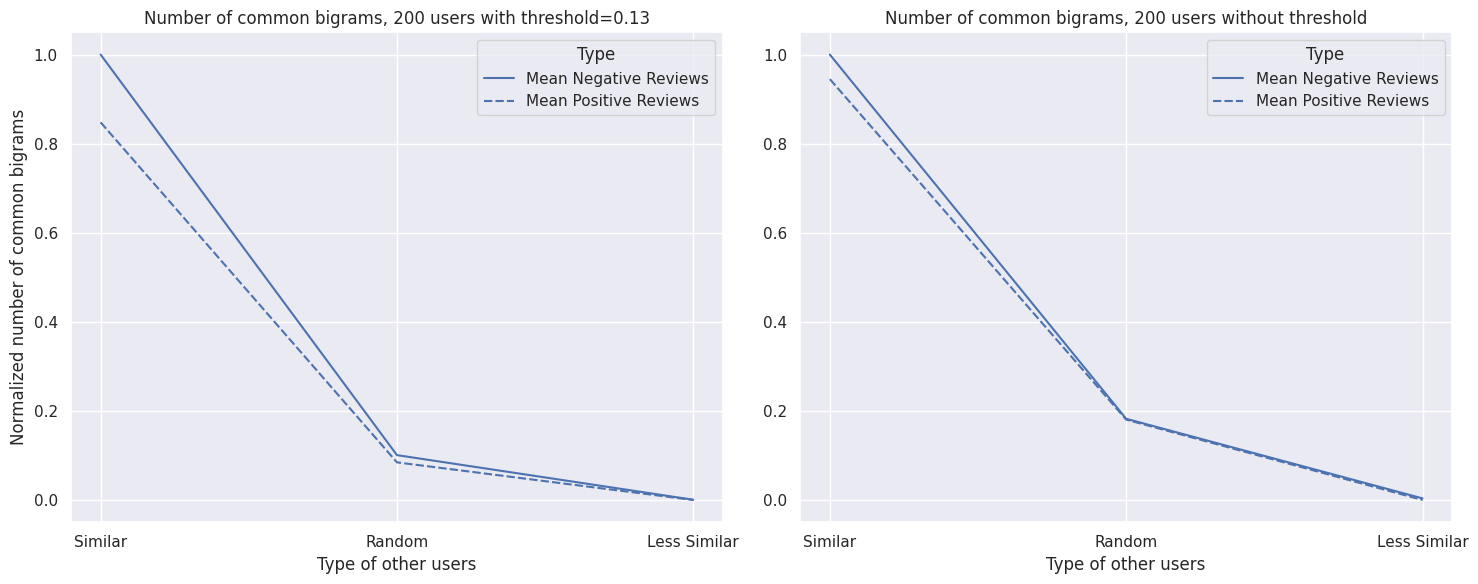

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=norm_t, x='User', y="count", style="Type", ax=ax[0])
ax[0].set_title("Number of common bigrams, 200 users with threshold=0.13")
ax[0].set_ylabel("Normalized number of common bigrams")
ax[0].set_xlabel("Type of other users")
sns.lineplot(data=norm_not, x='User', y="count", style="Type", ax=ax[1])
ax[1].set_title("Number of common bigrams, 200 users without threshold")
ax[1].set_ylabel("")
ax[1].set_xlabel("Type of other users")
plt.tight_layout()

plt.savefig("../images/diff_threshold_bigram_intersect.png")

### Proportion of user's bigrams in the intersection

In [54]:
np.random.seed(42)
bev.knn_comments_prop(208, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'simi', threshold = 0, k = 40, verbose = False)

(0.19358741681790684, 0.5025996533795494)

In [55]:
threshold = 0.13
n_users = 200
for _ in range(5):
    users_ids_samp = comments_all.sample(n=n_users)['User id']

    avg_pos_s_200 = []
    avg_neg_s_200 = []
    avg_pos_ls_200 = []
    avg_neg_ls_200 = []
    avg_pos_r_200 = []
    avg_neg_r_200 = []

    for id in users_ids_samp:
        # simi
        pos, neg = bev.knn_comments_prop(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'simi', threshold = threshold, k = 40)
        avg_pos_s_200.append(pos)
        avg_neg_s_200.append(neg)

        # less_simi
        pos, neg = bev.knn_comments_prop(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'less_simi', threshold = threshold, k = 40)
        avg_pos_ls_200.append(pos)
        avg_neg_ls_200.append(neg)

        # random
        pos, neg = bev.knn_comments_prop(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'random', threshold = threshold, k = 40)
        avg_pos_r_200.append(pos)
        avg_neg_r_200.append(neg)   


/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [56]:
print(f"Average proportion of user's bigrams in the intersection for 200 users thresold = {threshold}, k=40\
      \nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
      \nLess_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
      \nRandom pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

Average proportion of user's bigrams in the intersection for 200 users thresold = 0.13, k=40      
Simi pos: 0.03546571954527848, neg: 0.06337800786662114      
Less_simi pos: 0.0010147601087947384, neg: 0.001370895891767035      
Random pos: 0.0044156973593916385, neg: 0.009708505233677606



In [57]:
df_pos_neg = type_user_count_df(avg_pos_s_200, avg_pos_r_200, avg_pos_ls_200, avg_neg_s_200, avg_neg_r_200, avg_neg_ls_200)
group_means_reset = df_user_type_mean(df_pos_neg)

In [62]:
max(df_pos_neg[df_pos_neg["Type"] == "Negative Reviews"]['count'])

0.3779527559055118

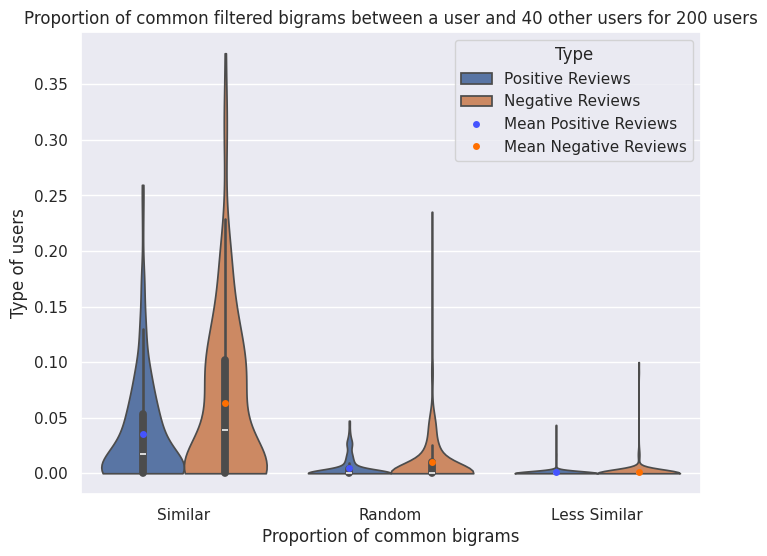

In [58]:
title = "Proportion of common filtered bigrams between a user and 40 other users for 200 users"
xlab = "Proportion of common bigrams"
ylab = "Type of users"

plot_posnegviolin(df_pos_neg, group_means_reset, title, xlab, ylab, "vplot_prop_big_200")

### Average neighbors' proportion of user's bigrams 

In [43]:
threshold = 0.13
n_users = 200
for _ in range(5):
    users_ids_samp = comments_all.sample(n=n_users)['User id']

    avg_pos_s_200 = []
    avg_neg_s_200 = []
    avg_pos_ls_200 = []
    avg_neg_ls_200 = []
    avg_pos_r_200 = []
    avg_neg_r_200 = []

    count_pos_s, count_neg_s = [],[]
    count_pos_ls, count_neg_ls = [],[]
    count_pos_r, count_neg_r = [],[]

    for id in users_ids_samp:
        # simi
        pos, neg, pos_count, neg_count = bev.knn_comments_norm(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'simi', threshold = threshold, k = 40)
        avg_pos_s_200.append(pos)
        avg_neg_s_200.append(neg)
        count_pos_s.append(pos_count)
        count_neg_s.append(neg_count)

        # less_simi
        pos, neg, pos_count, neg_count = bev.knn_comments_norm(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'less_simi', threshold = threshold, k = 40)
        avg_pos_ls_200.append(pos)
        avg_neg_ls_200.append(neg)
        count_pos_ls.append(pos_count)
        count_neg_ls.append(neg_count)

        # random
        pos, neg, pos_count, neg_count = bev.knn_comments_norm(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'random', threshold = threshold, k = 40)
        avg_pos_r_200.append(pos)
        avg_neg_r_200.append(neg)
        count_pos_r.append(pos_count)
        count_neg_r.append(neg_count)

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/ana

In [44]:
print(f"Average proportion of user's bigrams in other comments, for 200 users thresold = 0.13, k=40\
      \nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)},\nNb intersection pos : {np.mean(count_pos_s)}, neg : {np.mean(count_neg_s)}\
      \nLess_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)},\nNb intersection pos : {np.mean(count_pos_ls)}, neg : {np.mean(count_neg_ls)}\
      \nRandom pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}, \nNb intersection pos : {np.mean(count_pos_r)}, neg : {np.mean(count_neg_r)}\n")

Average proportion of user's bigrams in other comments, for 200 users thresold = 0.13, k=40      
Simi pos: 0.006343907263143271, neg: 0.004774169545174844,
Nb intersection pos : 7.855, neg : 9.46      
Less_simi pos: 0.0013059497028984324, neg: 0.00018849206349206348,
Nb intersection pos : 0.065, neg : 0.015      
Random pos: 0.004169069465926111, neg: 0.0024910320974544952, 
Nb intersection pos : 0.99, neg : 1.0



In [45]:
df_pos_neg = type_user_count_df(avg_pos_s_200, avg_pos_r_200, avg_pos_ls_200, avg_neg_s_200, avg_neg_r_200, avg_neg_ls_200)
group_means_reset = df_user_type_mean(df_pos_neg)

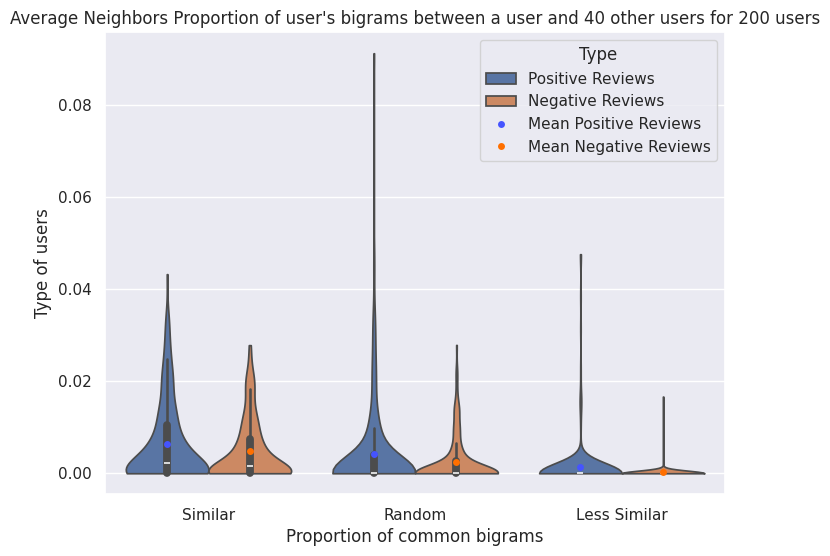

In [46]:
title = "Average Neighbors Proportion of user's bigrams between a user and 40 other users for 200 users"
xlab = "Proportion of common bigrams"
ylab = "Type of users"

plot_posnegviolin(df_pos_neg, group_means_reset, title, xlab, ylab, "vplot_norm_big_200")

In [40]:
np.random.seed(42)
bev.knn_comments_norm(208, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'simi', threshold = threshold, k = 40)

(0.04659640537462657, 0.009668687997623186, 86, 41)

In [41]:
np.random.seed(42)
bev.knn_comments_norm(208, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'less_simi', threshold = threshold, k = 40)

(0.0, 0.0, 0, 0)

In [42]:
np.random.seed(42)
bev.knn_comments_norm(208, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, type = 'random', threshold = threshold, k = 40)

(0.033349075707512825, 0.004519438238719903, 21, 9)